# Library Book Recommendation System

---
## Business Understanding
In the increasingly competitive landscape of online libraries and book platforms, personalized recommendation systems have emerged as a critical tool for enhancing user engagement, satisfaction, and retention. Understanding users' unique preferences, demographics, and reading habits is essential for delivering relevant and tailored book suggestions that resonate with individual tastes. By leveraging advanced algorithms and user data analytics, our platform aims to revolutionize the book discovery experience, offering users a curated selection of books that align with their interests and preferences. Through continuous iteration and optimization, we strive to create a dynamic and immersive user interface that not only facilitates book exploration but also fosters a sense of community and interaction among readers, ultimately driving business growth and differentiation in the competitive market.


---
## Problem Statement

The current landscape of online libraries and book platforms lacks personalized recommendation systems that effectively cater to individual users' preferences and reading habits. Existing platforms often rely on generic recommendations or fail to leverage user data to deliver relevant book suggestions, leading to suboptimal user experiences and limited engagement. Our platform aims to address this challenge by developing a robust and intuitive recommendation system that harnesses user data, ratings, and book information to provide personalized book recommendations tailored to each user's unique profile. By seamlessly integrating user registration, profile creation, and recommendation display functionalities into the user interface, we seek to empower users to discover new books that align with their interests and preferences while fostering a vibrant and engaging community of readers.

### Project Objectives
$i.$ Develop a personalized book recommendation engine that utilizes user data, ratings, and book information to generate tailored book suggestions for individual users based on their preferences, and reading history.

$ii.$ **Create User-Friendly Interface:** Develop an intuitive and user-friendly interface that facilitates seamless user registration, profile creation, and recommendation display. 


### Stakeholders
- End Users: These are the readers who will use the recommendation system to discover and enjoy books.
- Content Providers: These include authors and publishers who provide the books that are recommended by the system.
- Startup Team-ALGORETHMIC ALCHEMISTS: This includes everyone involved in building, maintaining, and improving the recommendation system.

### Metrics Of Success

The efficacy of our recommendation engine is reliant on its capacity to deliver personalized content tailored to the preferences of every book enthusiast on our platform. This personalized approach is deemed paramount for enhancing user engagement and satisfaction, ultimately leading to higher conversion rates of the recommended content.

In the realm of recommendation systems, the industry standard for mean absolute error (MAE) is typically set at 1.0 this is supported by the research paper published by Adomavicius & Tuzhilin, 2005 and subsequent paper published in 2017. However, to truly excel in this domain, higher aspirations have been set by us. Our goal is to develop a recommendation engine that consistently achieves a maximum MAE of below 1.0.

This ambitious commitment is underscored by the dedication to providing users with exceptionally accurate and precisely tailored book suggestions.






---
## Data Understanding

The data used in this project was obtained from [Kaggle](https://www.kaggle.com/code/fahadmehfoooz/book-recommendation-system/input?select=Books.csv). 
It comprises three different tables:

`Ratings`<br>
Contains the book rating information. Ratings (`Book-Rating`) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

`Books`<br>
Books are identified by their respective `ISBN`. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (`Book-Title`, `Book-Author`, `Year-Of-Publication`, `Publisher`), obtained from Amazon Web Services. Note that in case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon web site.

`Users`<br>
Contains the users. Note that user IDs (`User-ID`) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL-values.


Additional data was obtained from [Google Books API](https://developers.google.com/books) to provide more metadata on the books.

In [170]:
#Importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import re
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random

#modelling
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise import Reader, Dataset
from scipy.sparse import csr_matrix
from surprise.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [171]:
# Define custom color palette using hex codes
custom_palette = sns.color_palette("mako", n_colors=10) 

# Set the Seaborn theme with custom colors
sns.set_theme(palette=custom_palette, context="notebook", style="darkgrid")

**Loading Data**

In [172]:
#From Kaggle
#importing Ratings datasets
ratings = pd.read_csv('data/Ratings.csv', encoding= 'latin-1')

# importing users dataset
users = pd.read_csv('data/Users.csv', encoding= 'latin-1', on_bad_lines= 'skip')

# importing books datasets
books = pd.read_csv('data/Books.csv', encoding='latin-1', on_bad_lines='skip', dtype= str)

#importing the books queried from google books API
api_books = pd.read_csv('data/apibooks.csv')


**Ratings**

In [173]:
#exploring the dataset
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [174]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [175]:
#checking for duplicates
ratings.duplicated().sum()

0

In [176]:
#checking for number of unique users
ratings['User-ID'].nunique()

105283

In [177]:
#checking for unique books
ratings['ISBN'].nunique()

340556

For the rating dataset;
- The dataset has 3 features with **1,149,780** records
- The dataset has 105,283 unique users and 340556 different books rated by the users
- There are no missing values
- There are no duplicates

**Books**

In [178]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [179]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [180]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [181]:
#checking duplicates
books.duplicated().sum()

0

**Users**

In [182]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [183]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [184]:
users.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

### Data Cleaning

**Users table**

The age columns has over 110,000 missing values therefore dropping all these records will lead to loss of monumental information about the users which we can't afford to lose.

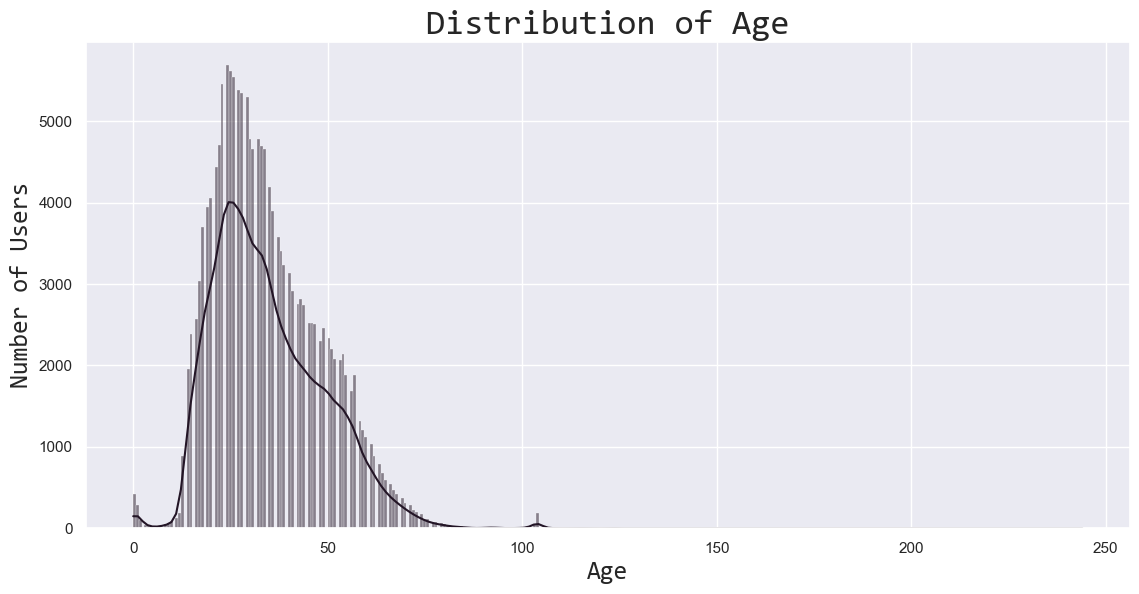

In [185]:
#examining the distribution of `age` column
fig, ax = plt.subplots(figsize = (12, 6))
sns.histplot(data= users, x= 'Age', kde= True)
ax.set_title('Distribution of Age', fontname='Consolas', fontsize = 25)
ax.set_xlabel('Age', fontname='Consolas', fontsize=18)
ax.set_ylabel('Number of Users', fontname='Consolas', fontsize=18);

Since the data is highly skewed, replacing the missing values with the mean wouldn't be ideal for this project. Instead, the missing values will be replaced by the median value, as it is not susceptible to the outliers.

In [17]:
#replacing the missing values
users['Age'].fillna(users['Age'].median(), inplace= True)

In [18]:
#sanity check
users.isna().sum()

User-ID     0
Location    0
Age         0
dtype: int64

From the histogram plot, it is observed that there are users with ages as low as 0 and as high as 250. However, in an ideal world, currently with advanced technology, it is assumed that the minimum age for a child to start reading by themselves would be 5 years. Additionally, individuals over 100 years would be least likely to read by themselves or interact with technology. For this project, ages below five years and over 100 years will be treated as most likely placeholders. They will be replaced with the median age.

In [19]:
# replacing the users with less than 5 year and over 100 years with median

users.loc[(users['Age'] < 5) | (users['Age'] > 100)] = users['Age'].median()

In [20]:
#previewing the dataset again
users.sample(10)

,User-ID,Location,Age
219558,219559,"calgary, alberta, canada",32.0
278816,278817,"urbandale, iowa, usa",60.0
265195,265196,"ibiza, baleares, spain",46.0
121716,121717,"hamilton, waikato, new zealand",56.0
85405,85406,"high wycombe, england, united kingdom",32.0
167448,167449,"summer hill, new south wales, australia",18.0
168112,168113,"oslo, n/a, norway",32.0
94976,94977,"stawell, victoria, australia",32.0
159305,159306,"fremont, california, usa",35.0
13050,13051,"new york, new york, usa",32.0


In this project's analysis, the Country was extracted from the `Location` column. Records with unidentifiable countries will have their null values replaced with `Other`, instead of being dropped.

In [21]:
# splitting a string into a list
users['Country'] = users['Location'].str.split(", ", expand = True)[2].str.strip()

#replacing the none countries with other

users['Country'].fillna('Other', inplace =  True)

In [22]:
#sanity check
users['Country'].isna().sum()

0

In [23]:
#dropping the location column

users.drop(columns = ['Location'], inplace = True)

In [24]:
#previewin the users table again

users.head()

,User-ID,Age,Country
0,1,32.0,usa
1,2,18.0,usa
2,3,32.0,russia
3,4,17.0,portugal
4,5,32.0,united kingdom


### Books Table

In [25]:
#sampling table to gain insights
books.sample(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
228821,0679449248,Zigzagging Down a Wild Trail: Stories,Bobbie Ann Mason,2001,Random House,http://images.amazon.com/images/P/0679449248.0...,http://images.amazon.com/images/P/0679449248.0...,http://images.amazon.com/images/P/0679449248.0...
65038,1568820461,"Made in Goatswood (Call of Cthulhu, No 8)",Ramsey Campbell,1995,Chaosium,http://images.amazon.com/images/P/1568820461.0...,http://images.amazon.com/images/P/1568820461.0...,http://images.amazon.com/images/P/1568820461.0...
248409,0874492416,Playtime With Baby Jay (Honey Bear Books),Bethea Verdorn,1987,Modern Publishing,http://images.amazon.com/images/P/0874492416.0...,http://images.amazon.com/images/P/0874492416.0...,http://images.amazon.com/images/P/0874492416.0...
120471,0679448454,Follow Me,Paul Griner,1996,Random House Inc,http://images.amazon.com/images/P/0679448454.0...,http://images.amazon.com/images/P/0679448454.0...,http://images.amazon.com/images/P/0679448454.0...
215160,0394472497,The condor passes,Shirley Ann Grau,1971,Knopf,http://images.amazon.com/images/P/0394472497.0...,http://images.amazon.com/images/P/0394472497.0...,http://images.amazon.com/images/P/0394472497.0...


The International Standard Book Number (ISBN) is a numeric commercial book identifier that is intended to be unique. ISBNs are purchased or received by publishers from an affiliate of the International ISBN Agency. The ISBN is ten digits long if assigned before 2007 and thirteen digits long if assigned on or after 1 January 2007. However, the data utilized in this project was collected in 2004, therefore, ISBNs less than 10 digits or more than 10 would be expected to be invalid.

In [26]:
#removing the whitespaces if there is any and lower all alphabets the the ISBNS
books['ISBN'] = books['ISBN'].str.replace(' ', '').str.lower()

In [27]:
#Identifying duplicate ISBN
books['ISBN'].duplicated().sum()

314

Since ISBNs are intended to be unique for each book, all the duplicated ISBNs are dropped.

In [28]:
#dropping the duplicates
books.drop_duplicates(subset=["ISBN"], inplace=True)

In [29]:
#sanity check
books['ISBN'].duplicated().sum()

0

In [30]:
#Identifying with ISBNS less than 10 and more than 10
books.loc[(books['ISBN'].apply(lambda x: len(x) > 10)) | (books['ISBN'].apply(lambda x: len(x) < 10))]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
111808,0486404242\t,War in Kind: And Other Poems (Dover Thrift Edi...,Stephen Crane,1998,Dover Publications,http://images.amazon.com/images/P/0486404242.0...,http://images.amazon.com/images/P/0486404242.0...,http://images.amazon.com/images/P/0486404242.0...
171206,3518365479<90,"Suhrkamp TaschenbÃ?ÃÂ¼cher, Nr.47, Frost",Thomas Bernhard,1972,Suhrkamp,http://images.amazon.com/images/P/3518365479.0...,http://images.amazon.com/images/P/3518365479.0...,http://images.amazon.com/images/P/3518365479.0...
251424,34422480273,Diamond Age. Die Grenzwelt.,Neal Stephenson,2000,Goldmann,http://images.amazon.com/images/P/3442248027.0...,http://images.amazon.com/images/P/3442248027.0...,http://images.amazon.com/images/P/3442248027.0...
251649,03857222060,Balzac and the Little Chinese Seamstress : A N...,DAI SIJIE,2002,Anchor,http://images.amazon.com/images/P/0385722206.0...,http://images.amazon.com/images/P/0385722206.0...,http://images.amazon.com/images/P/0385722206.0...


In [31]:
#droping the records
books.drop(books.loc[(books['ISBN']
                      .apply(lambda x: len(x) > 10)) | (books['ISBN']
                                                        .apply(lambda x: len(x) < 10))].index, inplace=True)

In [32]:
#sanity check
books.loc[(books['ISBN'].apply(lambda x: len(x) > 10)) | (books['ISBN'].apply(lambda x: len(x) < 10))]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L


In [33]:
#previewing the the cleaned books
books.sample(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
170069,0380760053,Tempest,Catherine Hart,1991,Harper Mass Market Paperbacks (Mm),http://images.amazon.com/images/P/0380760053.0...,http://images.amazon.com/images/P/0380760053.0...,http://images.amazon.com/images/P/0380760053.0...
55450,0785748814,Murder in the Mews and Other Stories (Hercule ...,Agatha Christie,1999,Sagebrush Bound,http://images.amazon.com/images/P/0785748814.0...,http://images.amazon.com/images/P/0785748814.0...,http://images.amazon.com/images/P/0785748814.0...
219616,0452270804,Hardball for Women: Winning at the Game of Bus...,"Pat, Ph.D. Heim",1993,Plume Books,http://images.amazon.com/images/P/0452270804.0...,http://images.amazon.com/images/P/0452270804.0...,http://images.amazon.com/images/P/0452270804.0...
118926,0312922396,Born Rich,Georgia Raye,1990,St Martins Pr (Mm),http://images.amazon.com/images/P/0312922396.0...,http://images.amazon.com/images/P/0312922396.0...,http://images.amazon.com/images/P/0312922396.0...
177288,0671557386,Voices in an Empty Room,Francis King,1986,Pocket Books,http://images.amazon.com/images/P/0671557386.0...,http://images.amazon.com/images/P/0671557386.0...,http://images.amazon.com/images/P/0671557386.0...


### Api Books

In [34]:
#previewing the api books
api_books.head()

,authors,published_date,description,isbn_10,isbn_13,page_count,categories,maturity_rating,language,join_isbn_10
0,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,Provides an introduction to classical myths pl...,0195153448,9780195153446.0,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an o...",IND:30000026059836,NaN,582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an o...",9780374157067,374157065.0,367.0,['Medical'],NOT_MATURE,en,0374157065
4,['E. J. W. Barber'],1999,A look at the incredibly well-preserved ancien...,0393045218,9780393045215.0,240.0,['Design'],NOT_MATURE,en,0393045218


In [35]:
#dropping the ISBN_10 and ISBN_13 since we shall use the last column join_isbn_10
api_books.drop(columns= ['isbn_10','isbn_13'], inplace= True)

In [36]:
api_books.head()

,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
0,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,Provides an introduction to classical myths pl...,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an o...",582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an o...",367.0,['Medical'],NOT_MATURE,en,0374157065
4,['E. J. W. Barber'],1999,A look at the incredibly well-preserved ancien...,240.0,['Design'],NOT_MATURE,en,0393045218


In [37]:
#merging the books from api and the cleaned books
book_df = books.merge(right= api_books, how= 'inner', right_on= 'join_isbn_10', left_on= 'ISBN')

In [38]:
book_df.shape

(249026, 16)

In [39]:
#previewing the merged books df

book_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,"['Mark P. O. Morford', 'Robert J. Lenardon']",2003,Provides an introduction to classical myths pl...,808.0,['Social Science'],NOT_MATURE,en,0195153448
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0002005018
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,"[""Carlo D'Este""]",1991,"Here, for the first time in paperback, is an o...",582.0,['1940-1949'],NOT_MATURE,en,0060973129
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,['Gina Bari Kolata'],1999,"Describes the great flu epidemic of 1918, an o...",367.0,['Medical'],NOT_MATURE,en,0374157065
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,['E. J. W. Barber'],1999,A look at the incredibly well-preserved ancien...,240.0,['Design'],NOT_MATURE,en,0393045218


When importing the books data, it was noticed that there were mixed data types. Therefore, before beginning the analysis, it would be better to examine the cause of this in the 3rd column (`Year-Of-Publication`) before proceeding with the exploratory data analysis (EDA).

In [40]:
#Checking inique values for years
book_df['Year-Of-Publication'].unique()

array(['2002', '2001', '1991', '1999', '2000', '1993', '1996', '1988',
       '2004', '1998', '1994', '2003', '1997', '1995', '1982', '1985',
       '1992', '1986', '1978', '1980', '1983', '1952', '1987', '1981',
       '1990', '1989', '1984', '0', '1968', '1961', '1958', '1974',
       '1976', '1971', '1977', '1975', '1965', '1941', '1970', '1962',
       '1972', '1960', '1979', '1966', '1920', '1973', '1956', '1959',
       '1953', '1951', '1942', '1963', '1964', '1969', '1950', '1967',
       '2005', '1957', '1937', '1955', '1954', '1946', '1930', '2011',
       '1925', '1948', '1943', '1947', '1923', '1939', '1926', '1938',
       '2030', '1940', '1911', '1949', '1932', '1928', '1929', '1945',
       '1927', '1936', '1931', '1914', '2050', '1934', '1910', '1933',
       '1902', '1924', '1921', '2038', '2026', '1944', '1917', '1901',
       '2010', '1908', '1906', '1935', '1806', '2021', '2012', '2006',
       '1900', 'Gallimard', 'DK Publishing Inc', '1909', '1378', '1919',
       

It is noticed that there are values such as `DK Publishing Inc` and `Gallimard`, which are not ideal for years. Therefore, the rows with these values will be examined.

In [41]:
#previewing the records with wrong years
book_df.loc[(book_df['Year-Of-Publication'] == 'DK Publishing Inc') 
            | (book_df['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
202625,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN,['Jean-Marie Gustave Le ClÃ©zio'],2002,Deux enfants vivent une expÃ©rience qui boulev...,132.0,['Fiction'],NOT_MATURE,fr,2070426769
203486,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN,"['James Buckley (Jr.)', 'Michael Teitelbaum']",2000,"Meet the artists, writers and others who make ...",54.0,['Graphic novels'],NOT_MATURE,en,0789466953


Instead of dropping these records, the `Book-Author`, `Year-Of-Publication`, and `Publisher` columns will be fixed for these records using the available information. It is noticed that the year of publication was moved to the book author column at the time of recording, while the publisher was recorded in the year of publication column. The book author can be found from the authors column.

In [45]:
publication_dict = {'DK Publishing Inc': 2000, 'Gallimard': 2003}

# Update 'Year-Of-Publication'
book_df.loc[book_df['Publisher'].isin(publication_dict.keys()), 'Year-Of-Publication'] = book_df['Publisher'].map(publication_dict)

# Fixing book author
book_df.loc[203486, 'Book-Author'] = 'James Buckley (Jr.)'
book_df.loc[202625, 'Book-Author'] = 'Jean-Marie Gustave Le Clézio'

# Fixing the publisher
book_df.loc[203486, 'Publisher'] = 'DK Publishing Inc'
book_df.loc[202625, 'Publisher'] = 'Gallimard'


In [46]:
#sanity check
book_df.loc[(book_df['Year-Of-Publication'] == 'DK Publishing Inc') 
            | (book_df['Year-Of-Publication'] == 'Gallimard')]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10


In [47]:
#converting the year column to integer
book_df['Year-Of-Publication'] = book_df['Year-Of-Publication'].astype(int)

In [48]:
#Rechecking the values of years dataset
book_df['Year-Of-Publication'].value_counts().sort_index(ascending= False)[:20]

Year-Of-Publication
2050        2
2038        1
2030        7
2026        1
2024        1
2021        1
2012        1
2011        2
2010        2
2006        3
2005       39
2004     5344
2003    13807
2002    16006
2001    15767
2000    15788
1999    15895
1998    14470
1997    13601
1996    12877
Name: count, dtype: int64

#

Considering that the main dataset utilized in this project was collected in 2004, it's essential to inspect the columns containing years above 2004.

In [49]:
#inspecting the columns that have years above 2004

book_df.loc[book_df['Year-Of-Publication'] > 2004].sample(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10
203973,1552782662,The Shanghai Murders,David Rotenberg,2005,McArthur &amp; Company,http://images.amazon.com/images/P/1552782662.0...,http://images.amazon.com/images/P/1552782662.0...,http://images.amazon.com/images/P/1552782662.0...,['David Rotenberg'],2004,The first in the series of mysteries featuring...,316.0,['Fiction'],NOT_MATURE,en,1552782662
226554,0380000059,CLOUT,D. GIBBONS,2024,Avon,http://images.amazon.com/images/P/0380000059.0...,http://images.amazon.com/images/P/0380000059.0...,http://images.amazon.com/images/P/0380000059.0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0380000059


Given the dataset's size, we can afford to lose the 72 records containing such unrealistic publication years. Therefore, we will drop all records where the year of publication is above 2004. Additionally, some dates may be unreasonable, and removing them will help ensure the dataset's quality and accuracy.

There are also records where the year of publication is 0. Given we can't have a zero year, they are problably place holders. For this project, we shall drop the records with zero as the year of publication.

In [50]:
#sling to have only records with year of publication above 0
book_df = book_df.loc[book_df['Year-Of-Publication'] > 0]

In [51]:
#sanity check
book_df.loc[book_df['Year-Of-Publication'] == 0]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10


In [52]:
#slicing to have only records with year of publication 2004 and below
book_df = book_df.loc[book_df['Year-Of-Publication'] < 2005]

In [53]:
#sanity check
book_df.loc[book_df['Year-Of-Publication'] > 2004]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,published_date,description,page_count,categories,maturity_rating,language,join_isbn_10


In [54]:
#dropping some duplicate features

book_df.drop(columns= ['join_isbn_10','authors','published_date' ], inplace= True)

In [55]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244775 entries, 0 to 249025
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 244775 non-null  object 
 1   Book-Title           244775 non-null  object 
 2   Book-Author          244773 non-null  object 
 3   Year-Of-Publication  244775 non-null  int32  
 4   Publisher            244774 non-null  object 
 5   Image-URL-S          244775 non-null  object 
 6   Image-URL-M          244775 non-null  object 
 7   Image-URL-L          244773 non-null  object 
 8   description          163876 non-null  object 
 9   page_count           191275 non-null  float64
 10  categories           180364 non-null  object 
 11  maturity_rating      192488 non-null  object 
 12  language             192488 non-null  object 
dtypes: float64(1), int32(1), object(11)
memory usage: 25.2+ MB


- **Handling the categories column**



In [56]:
#inspecting the first 5 rows
book_df.sample(5)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,description,page_count,categories,maturity_rating,language
161476,0891903771,Cop Killer: The Story of a Crime,Maj Sjowall,1986,Amereon Ltd,http://images.amazon.com/images/P/0891903771.0...,http://images.amazon.com/images/P/0891903771.0...,http://images.amazon.com/images/P/0891903771.0...,NaN,NaN,NaN,NaN,NaN
201175,1898680299,Guide for the Development of Mediumship,Harry Edwards,2003,Con-Psy Publications,http://images.amazon.com/images/P/1898680299.0...,http://images.amazon.com/images/P/1898680299.0...,http://images.amazon.com/images/P/1898680299.0...,NaN,48.0,['Mediums'],NOT_MATURE,en
178131,0375727442,The Fatal Englishman: Three Short Lives,Sebastian Faulks,2002,Vintage Books USA,http://images.amazon.com/images/P/0375727442.0...,http://images.amazon.com/images/P/0375727442.0...,http://images.amazon.com/images/P/0375727442.0...,"In The Fatal Englishman, his first work of non...",0.0,['Biography & Autobiography'],NOT_MATURE,en
213478,0446912077,Hold That Thought,Sarah Ban Breathnach,1997,Warner Books,http://images.amazon.com/images/P/0446912077.0...,http://images.amazon.com/images/P/0446912077.0...,http://images.amazon.com/images/P/0446912077.0...,NaN,NaN,NaN,NaN,NaN
201250,0752215078,Viz Roger's Profanisaurus,Roger Mellie,2002,Pan Macmillan,http://images.amazon.com/images/P/0752215078.0...,http://images.amazon.com/images/P/0752215078.0...,http://images.amazon.com/images/P/0752215078.0...,No lavatory is complete without a Profanisauru...,247.0,['Fiction'],NOT_MATURE,en


In [57]:
#Replacing the null values with Undefined
book_df['categories'].fillna('Undefined', inplace= True)

In [58]:
# Removing unwanted characters and split the string into a list
book_df['categories'] = book_df['categories'] \
                            .str.replace("[", "") \
                            .str.replace("]", "") \
                            .str.replace("'", "") \
                            .str.replace('"', "") \
                            .str.split(", ") 
#exploding the list of categories to individual categories in new rows
book_df = book_df.explode(column= 'categories', ignore_index= True)

In [59]:
#coverting categories to lowercase
book_df['categories'] = book_df['categories'].str.lower()

- Handling  page count column

In [60]:
#replacing page count with median page count

book_df['page_count'].fillna(book_df['page_count'].median(), inplace= True)

- Handling description column

In [61]:
#dropping the records with missng values in description column
book_df.dropna(subset= ['description'], inplace = True)

In [62]:
book_df.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              1
Image-URL-S            0
Image-URL-M            0
Image-URL-L            2
description            0
page_count             0
categories             0
maturity_rating        0
language               0
dtype: int64

In [63]:
#dropping the remaining missing value
book_df.dropna(inplace= True)

In [64]:
#sanity check
book_df.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
description            0
page_count             0
categories             0
maturity_rating        0
language               0
dtype: int64

In [65]:
#checking the first few rows of description
book_df['description'].head()

0    Provides an introduction to classical myths pl...
2    Here, for the first time in paperback, is an o...
3    Describes the great flu epidemic of 1918, an o...
4    A look at the incredibly well-preserved ancien...
5    A Chinese immigrant who is convinced she is dy...
Name: description, dtype: object

In [66]:
#defining function to clean the description column
def cleaning_description(description):
    # Removing any HTML tags from the description
    description = re.sub(r"<[^>]*>", "", description)
    
    # Replacing any non-alphabetic characters with a space
    description = re.sub(r"[^a-zA-Z]", " ", description)

    # Tokenizing the description
    tokens = word_tokenize(description)

    # Removing any stop words from the description
    stop_words = set(stopwords.words('english'))
    
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Performing lemmatization
    lemmatizer = WordNetLemmatizer()
    
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Joining the tokens back into a single string
    cleaned_description = " ".join(tokens)

    return cleaned_description

In [67]:
#applying the function to the description column
book_df['cleaned_description'] = (book_df['description']
                                  .apply(lambda x: cleaning_description(x) if isinstance(x, str) else ""))

- Sorting the maturity rating and Languange

In [68]:
# capitalizing the maturity rangings

book_df['maturity_rating'] = book_df['maturity_rating'].str.capitalize()

#language abreviation to upper case

book_df['language'] = book_df['language'].str.upper()

**Rating Table**

In [69]:
ratings.shape

(1149780, 3)

In [70]:
#preview the dataset
ratings.sample(5)

,User-ID,ISBN,Book-Rating
1013678,242824,0821754106,0
207203,47793,0451184963,0
1097070,263326,0812524268,0
586518,141601,2707317322,0
237703,55438,067101420X,7


In [71]:
#removing the whitespaces if there is any and lower all alphabets the the ISBNS
ratings['ISBN'] = ratings['ISBN'].str.replace(' ', '').str.lower()

In [72]:
#checking the ISBN if correct
ratings.loc[(ratings['ISBN'].apply(lambda x: len(x) > 10 )) | (ratings['ISBN'].apply(lambda x: len(x) < 10))]

,User-ID,ISBN,Book-Rating
9,276745,342310538,10
40,276762,342662429,0
55,276762,n3453124715,4
247,276856,20103389,0
291,276861,344242529,9
...,...,...,...
1149238,276641,033031582,5
1149358,276670,00969754916,7
1149428,276670,15655122046,6
1149439,276670,55305663,6


It's noticed that there are about 10500 records with invalid ISBNs. These records are therefore dropped.

In [73]:
#droping the invalid ISBN
ratings.drop(ratings.loc[(ratings['ISBN']
                      .apply(lambda x: len(x) > 10)) | (ratings['ISBN']
                                                        .apply(lambda x: len(x) < 10))].index, inplace=True)

In [74]:
#Sanity check
ratings.loc[(ratings['ISBN'].apply(lambda x: len(x) > 10 )) | (ratings['ISBN'].apply(lambda x: len(x) < 10))]

,User-ID,ISBN,Book-Rating


In the data description, it was observed that explicit ratings were provided by users to express their sentiments toward a book, using a scale of 1 to 10. Additionally, implicit ratings were denoted by a zero. For this project, the explicit ratings from each user will be utilized, as they provide insight into the user's emotional response to the content they have engaged with. This decision is based on the understanding that explicit ratings convey the user's feelings more directly compared to implicit ratings, which may not necessarily reflect their sentiment accurately.

In [75]:
#segragating only explicit ratings
ratings_explicit = ratings.loc[ratings['Book-Rating'] != 0]

For the analysis in this project, a decision has been made to limit only users who have rated at least 100 books to mitigate the potential biases introduced by users with sparse rating behavior, thereby ensuring that the recommendations are based on more robust and representative user preferences. Furthermore, the utilization of data from highly active users is expected to contribute to enhancing the performance of the model's predictions by providing a richer and more diverse dataset to train upon, ultimately leading to more effective and personalized book recommendations.

In [130]:
#getting user ratings count
user_ratings_count = ratings_explicit.groupby('User-ID')['ISBN'].nunique()

#geting users with atleart 100 ratings
users_with_at_least_100_ratings = user_ratings_count[user_ratings_count >= 100].index.tolist()

#subseting to have only users with atlearst 100 ratings in final df
ratings_final = ratings_explicit[ratings_explicit['User-ID'].isin(users_with_at_least_100_ratings)]

#previewing the final rating df
ratings_final.head()

,User-ID,ISBN,Book-Rating
14854,2276,0020960808,10
14856,2276,0030632366,9
14858,2276,0061030643,8
14860,2276,0061098353,8
14861,2276,0061099155,9


- Merging the users table to rating table

In [77]:
#merging on User-ID
users_and_rating = users.merge(right= ratings_final, on= 'User-ID')
users_and_rating.shape

(116427, 5)

In [78]:
users_and_rating.isna().sum()

User-ID        0
Age            0
Country        0
ISBN           0
Book-Rating    0
dtype: int64

- Merging users and ratings with cleaned books

In [79]:
#merging on ISBN

final_df = users_and_rating.merge(right= book_df, on= 'ISBN')

final_df.shape

(78376, 18)

In [80]:
#previwing sample 

final_df.sample(3)


,User-ID,Age,Country,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,description,page_count,categories,maturity_rating,language,cleaned_description
2822,229741,29.0,usa,0684800713,8,Sun Also Rises,Ernest Hemingway,1995,Scribner,http://images.amazon.com/images/P/0684800713.0...,http://images.amazon.com/images/P/0684800713.0...,http://images.amazon.com/images/P/0684800713.0...,A profile of the Lost Generation captures life...,258.0,fiction,Not_mature,EN,profile Lost Generation capture life among exp...
70526,197659,49.0,usa,0789419742,10,Dorling Kindersley World Atlas (1st ed),Andrew Heritage,1997,Dorling Kindersley,http://images.amazon.com/images/P/0789419742.0...,http://images.amazon.com/images/P/0789419742.0...,http://images.amazon.com/images/P/0789419742.0...,Maps detailing the world's geography include i...,380.0,atlases,Not_mature,EN,Maps detailing world geography include informa...
67485,182085,32.0,germany,0451196856,9,The Most Wanted,Jacquelyn Mitchard,1999,Signet Book,http://images.amazon.com/images/P/0451196856.0...,http://images.amazon.com/images/P/0451196856.0...,http://images.amazon.com/images/P/0451196856.0...,"Relates the story of a Texas teenaged girl, he...",420.0,fiction,Not_mature,EN,Relates story Texas teenaged girl outlaw husba...


In [81]:
final_df.isna().sum()

User-ID                0
Age                    0
Country                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
description            0
page_count             0
categories             0
maturity_rating        0
language               0
cleaned_description    0
dtype: int64

---
## Exploratory Data Analysis

**Books**

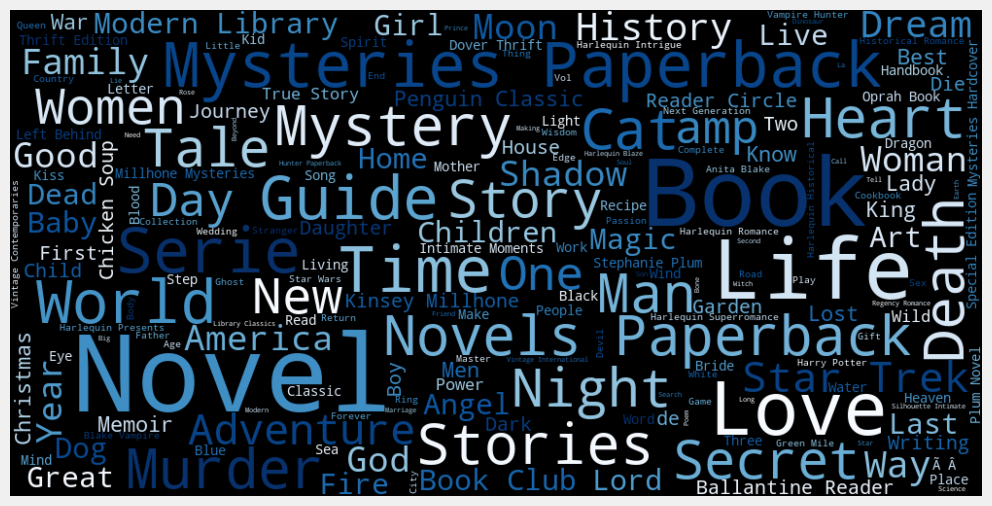

In [83]:
#creating a word cloud for titles
def create_wordcloud(text):
    # Create a WordCloud object
    wordcloud = WordCloud(width = 1000, height = 500, random_state=21, max_font_size=110, colormap='Blues').generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

# Concatenate all book titles in the 'Book-Title' column
book_titles = ' '.join(final_df['Book-Title'])

# Create and display the word cloud
create_wordcloud(book_titles)

- Words like “Mystery” and “Adventure” suggest suspense and action, which can create intrigue and encourage readers to pick up the book to discover more.
- The prominence of themes like “Love”, “Family”, “Women”, and “World” indicates that these universal experiences and emotions resonate with many readers.
- “Novel” and “Book” are common terms used in the literary world, and “Stories” is a fundamental concept in literature

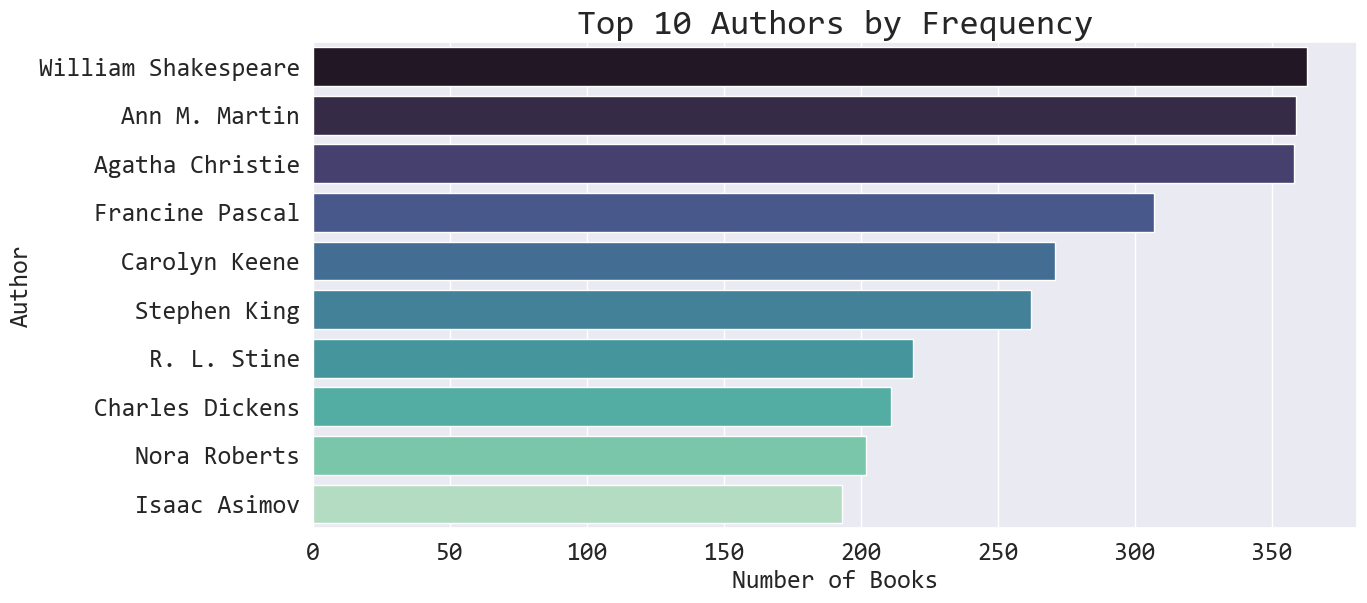

In [190]:
# Top 10 authors 
plt.figure(figsize=(12, 6))
top_authors = book_df['Book-Author'].value_counts().head(10)
sns.barplot(x=top_authors.values, y=top_authors.index, palette=custom_palette)
plt.title('Top 10 Authors by Frequency', fontname='Consolas', fontsize=25)
plt.xlabel('Number of Books', fontname='Consolas', fontsize=18)
plt.ylabel('Author', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

Authors like William Shakespeare, Ann M. Martin, and Agatha Christie have written a significant number of books and could be popular among readers. Recommending other books from these authors to readers who have enjoyed their previous works could be beneficial.

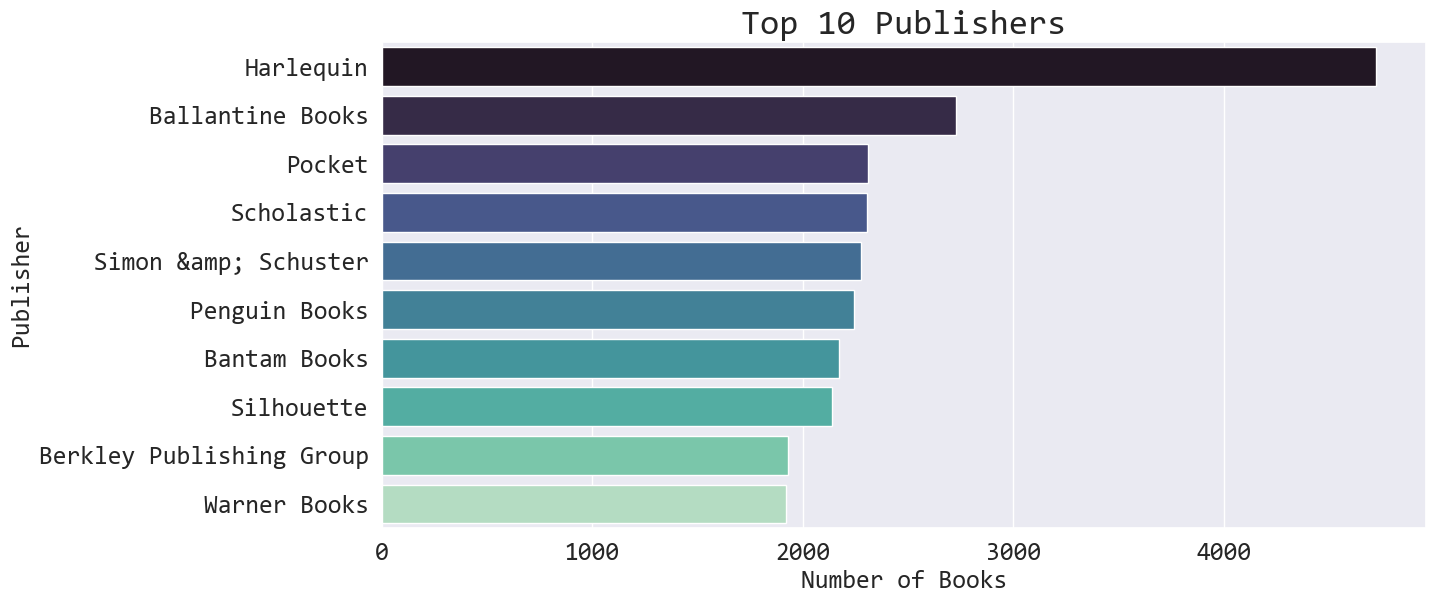

In [192]:
# Univariate Analysis for 'Publisher'
plt.figure(figsize=(12, 6))
top_publishers = book_df['Publisher'].value_counts().head(10)
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette=custom_palette)
plt.title('Top 10 Publishers', fontname='Consolas', fontsize = 25)
plt.xlabel('Number of Books', fontname='Consolas', fontsize = 18)
plt.ylabel('Publisher', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

Harlequin has published significantly more books than any other publisher.

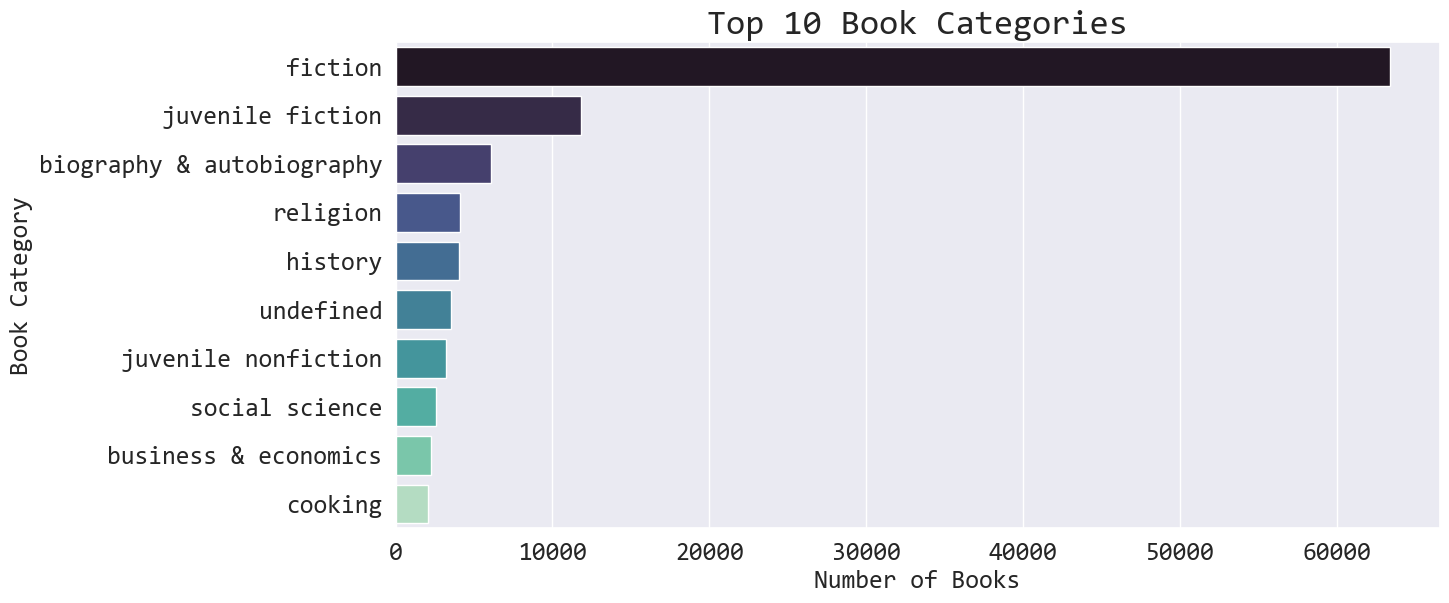

In [193]:
# Univariate Analysis for 'categories'
# Get the top 10 categories by frequency
top_10_categories = book_df['categories'].explode().value_counts().head(10)
# Plot the count plot for the top 10 categories
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_categories.values, y=top_10_categories.index, palette=custom_palette)
plt.title('Top 10 Book Categories', fontname='Consolas', fontsize=25)
plt.xlabel('Number of Books', fontname='Consolas', fontsize=18)
plt.ylabel('Book Category', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

- Fiction books, including Juvenile Fiction, tend to have a wide appeal. They are enjoyed by readers of all ages, which could lead to a higher number of books in these categories.
- Fiction allows authors to explore their creativity and imagination, leading to diverse and engaging stories. This could attract more readers and result in a higher number of books being written in these categories

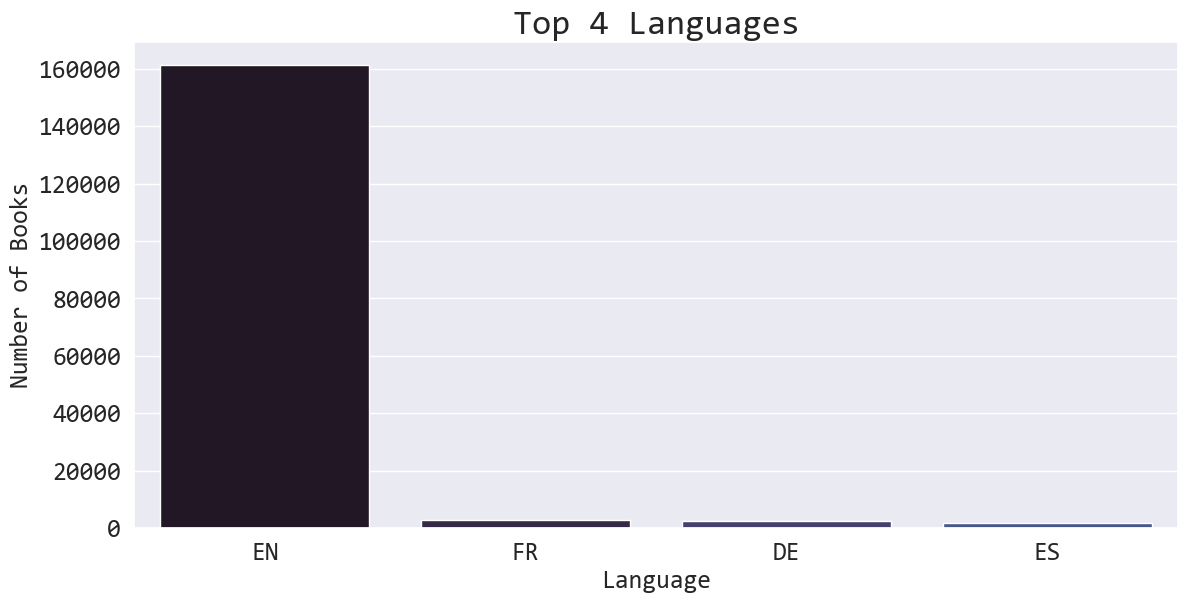

In [194]:
# Get the top 4 languages by frequency
top_4_languages = book_df['language'].value_counts().head(4).index

# Filter the dataframe to include only the top 4 languages
book_df_top_4_languages = book_df[book_df['language'].isin(top_4_languages)]

# Plot the count plot for the top 4 languages
plt.figure(figsize=(12, 6))
sns.countplot(data=book_df_top_4_languages, x='language', order=top_4_languages, palette=custom_palette)
plt.title('Top 4 Languages', fontname='Consolas', fontsize= 25)
plt.xlabel('Language', fontname='Consolas', fontsize=18)
plt.ylabel('Number of Books', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

- English is the primary language in the USA, and many of these publishers primarily publish books in English. This could lead to a higher number of books in English.

- English is spoken by many people around the world, not just in countries where it is the official language. This wide reach makes English a common choice for writing books

**Users**

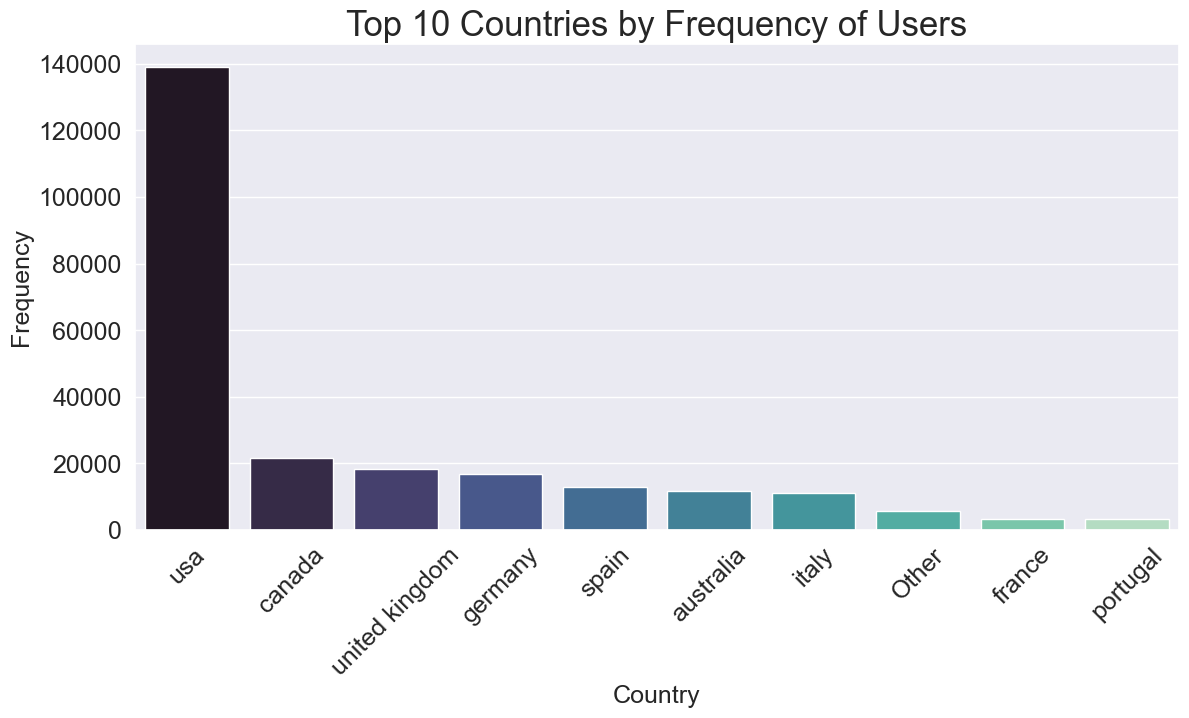

In [199]:
# Plot the frequency of users for the top 10 countries
plt.figure(figsize=(12, 6))
sns.countplot(data=users_top_10_countries, x='Country', order=top_10_countries, palette=custom_palette)
plt.title('Top 10 Countries by Frequency of Users', fontsize=25)
plt.xlabel('Country', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
plt.show()

- Most books are written in English, which is the primary language in the USA. This could make a book recommender system more appealing to users in the USA.
- The USA has a larger population compared to the other countries on the list, leading to a higher number of potential users.

- Many of the top publishers listed, such as Simon & Schuster, Scholastic, and Warner Books, are based in the USA. These publishers have a significant presence in the country, leading to a higher availability and accessibility of books.


**Ratings**

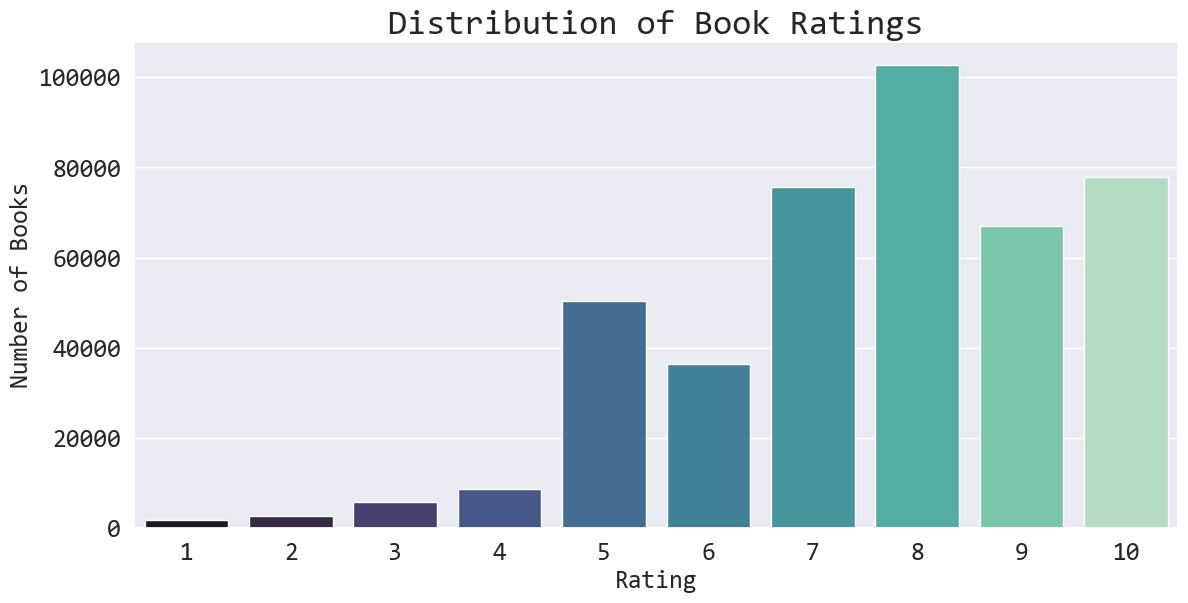

In [200]:
# Distribution of book ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=ratings_explicit, x='Book-Rating', palette=custom_palette) 
plt.title('Distribution of Book Ratings', fontname='Consolas', fontsize= 25)
plt.xlabel('Rating', fontname='Consolas', fontsize=18)
plt.ylabel('Number of Books', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()

Most books in the dataset have received a rating of 7, 8, or 9. Recommending books with similar high ratings could lead to higher user satisfaction.

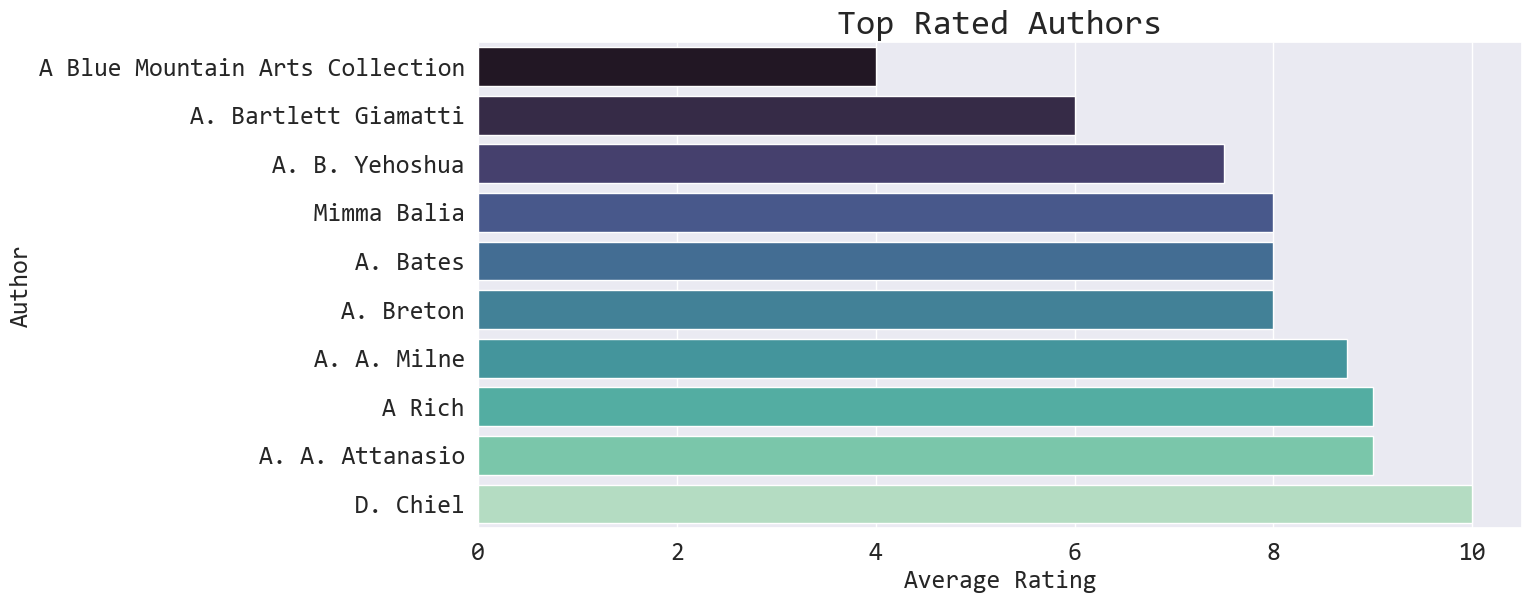

In [201]:
# Top rated authors
top_rated_authors_ = final_df.groupby(by=['Book-Author'])['Book-Rating'].mean().head(10)

# Sorting values in ascending order
top_rated_authors_sorted = top_rated_authors_.sort_values()

plt.figure(figsize = (12,6))
sns.barplot(x=top_rated_authors_sorted.values, y=top_rated_authors_sorted.index, palette=custom_palette)
plt.title('Top Rated Authors', fontname='Consolas', fontsize= 25)
plt.xlabel('Average Rating', fontname='Consolas', fontsize=18)
plt.ylabel('Author', fontname='Consolas', fontsize=18)
plt.xticks(fontname='Consolas', fontsize=18)
plt.yticks(fontname='Consolas', fontsize=18)
plt.show()


D. Chiel has the highest rating, close to 10.
Other authors listed include A. A. Attanasio, A. Rich, A. A. Milne, A. Breton, A. Bates, Mimma Balia, A.B.Yehoshua, and A.Bartlett Giamatti.

## Feature Engineering

***Age Grouping:*** Using the `pd.cut` function, the 'Age' column is binned into various age groups, including 'Child', 'Young Adult', 'Adult', and 'Senior'. This process results in the creation of a new categorical feature that represents the age group of each user.

In [90]:
#creating age group column
final_df['age_group'] = (pd.cut(final_df['Age'],
                                bins=[0, 18, 35, 60, 120],
                                labels=['Child', 'Young Adult', 'Adult', 'Senior']))

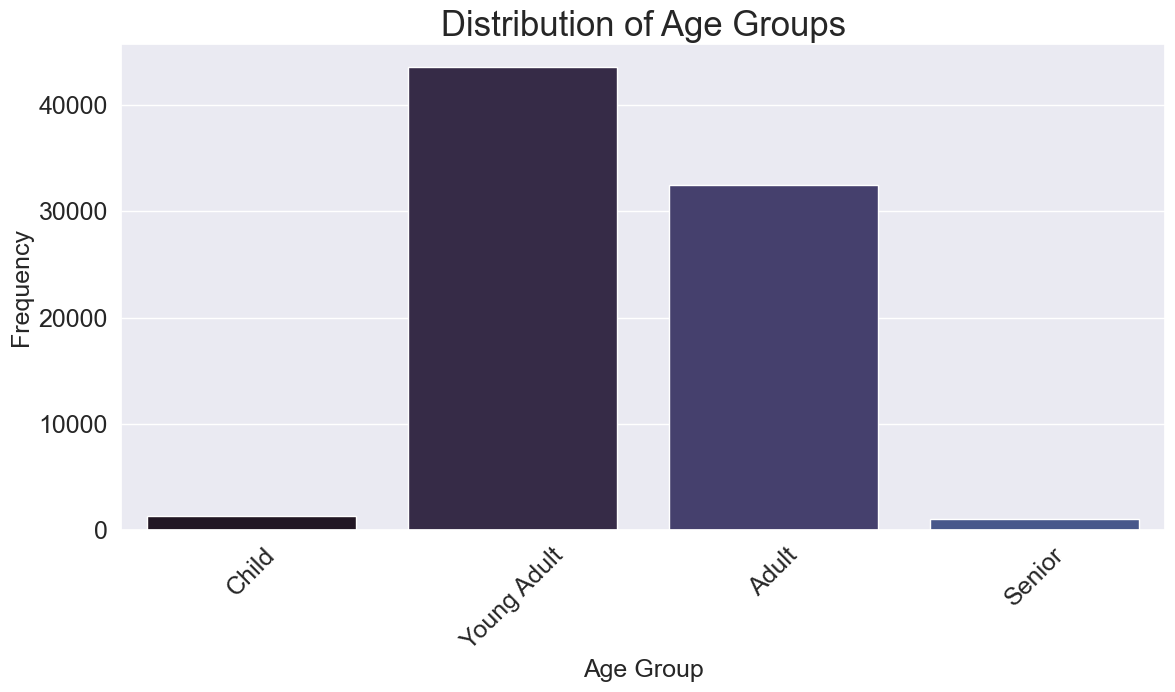

In [205]:
# Value counts for 'Age_Group' column
age_group_counts = final_df['age_group'].value_counts()

# Plot age groups
plt.figure(figsize=(12, 6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette=custom_palette)
plt.title('Distribution of Age Groups',  fontsize= 25)
plt.xlabel('Age Group',  fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(rotation = 45, fontsize=18)
plt.yticks(fontsize=18)
plt.show()

With the rise of digital reading platforms, access to books has become easier. Adults and Young Adults, being generally more tech-savvy, might be leveraging these platforms more, contributing to their higher usage.

---
## Modelling

Three different recommendation algorithms will be explored in our final model:

1. A popularity-based recommendation engine.
2. Collaborative filtering
3. Content-based filtering, where the following columns will be utilized:
   - Book-Title
   - Book-Author
   - Categories
   - Publisher
   - Description

**4.1 Popularity based recommendation**

In [92]:
# Defining a function to return the most popular books
def popular_books(df, n = 5):
    """Returns the n most popular books from the dataset.

    Parameters:
        df (DataFrame): DataFrame containing the ratings information.
        n (int): Number of books to return.

    Returns:
        numpy.ndarray: Book titles of the top n most popular books.
    """

    # Calculating the number of ratings and the average rating for each book by grouping the DataFrame by ISBN 
    # and aggregating the count of ratings and the mean rating.
    popular_books_df = (
        df.groupby("ISBN").agg({"Book-Rating": ["count", "mean"]}).reset_index()
    )
    popular_books_df.columns = ["ISBN", "NumberOfVotes", "AverageRatings"]

    # Calculating the popularity score for each book using a weighted average of the rating and number of votes
    C = popular_books_df["AverageRatings"].mean()

    m = popular_books_df["NumberOfVotes"].quantile(0.90)
    popular_books_df["Popularity"] = (
        popular_books_df["NumberOfVotes"] * popular_books_df["AverageRatings"] + m * C
    ) / (popular_books_df["NumberOfVotes"] + m)

    # Sorting the books in descending order by popularity score
    popular_books_df.sort_values(by="Popularity", ascending=False, inplace=True)

    # Merging popularity score with the books dataframe
    popular_books_df = popular_books_df.merge(books, on="ISBN", how="left")

    # Dropping the duplicate book titles
    popular_books_df.drop_duplicates(subset="Book-Title", inplace=True)

    # Return the top n most popular book titles
    book_list = popular_books_df["Book-Title"].head(n).values
    print(f'The top {n} popular books:')
    print('-------')
    for book in book_list:
        print(book)

In [93]:
#testing the funtion
popular_books(final_df, 5)

The top 5 popular books:
-------
More Than Complete Hitchhiker's Guide
Dune (Remembering Tomorrow)
My Sister's Keeper : A Novel (Picoult, Jodi)
Where the Red Fern Grows
How to Do Just About Anything/a Money-Saving A-To Z Guide to over 1,200 Practical Problems


**4.2 Collaborative filtering**

The performances of memory-based filtering and model-based filtering will be compared. The best-performing model will be selected to make predictions for subsequent functions that will be built. This involves evaluating the accuracy of each filtering method using  Mean Absolute Error (MAE) on a test dataset. Once the performances are assessed, the model with the lowest error metric will be chosen as the optimal solution for generating predictions in subsequent tasks.

**4.2.1 Baseline Model**

In [131]:
#instanting the reader
reader = Reader(rating_scale= (1, 10))
data = Dataset.load_from_df(ratings_final, reader)

dataset = data.build_full_trainset()

In [132]:
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  144 

Number of items:  53390


In [133]:
#Building the baseline model
knn_basic = KNNBasic(sim_options={'name':'pearson', 'user_based': True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [167]:
#evaluating the baseline model performance
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_mae']))

('test_rmse', array([1.90790342, 1.93685901, 1.93975745, 1.91587994, 1.91529624]))
('test_mae', array([1.53089309, 1.55527919, 1.55090916, 1.53666207, 1.54122048]))
('fit_time', (0.06995606422424316, 0.06096291542053223, 0.08194923400878906, 0.0859520435333252, 0.02700662612915039))
('test_time', (0.593660831451416, 0.5317046642303467, 0.513707160949707, 0.5386900901794434, 0.23784303665161133))
-----------------------
1.5429927982838545


The baseline model has been observed to exhibit an average mean absolute error of 1.5. Further exploration of additional models is conducted to assess whether the model performance can be enhanced to achieve better generalization on unseen data. 

**4.2.2 KNNBaseline Model**

In [135]:
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [136]:
#evaluating the models performance
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_mae'])

('test_rmse', array([1.56346084, 1.56388183, 1.55436291, 1.5380073 , 1.55858425]))
('test_mae', array([1.14287031, 1.13333158, 1.13666031, 1.12801925, 1.13745201]))
('fit_time', (0.5167059898376465, 0.5606765747070312, 0.6226413249969482, 0.6026532649993896, 0.4497401714324951))
('test_time', (0.28383541107177734, 0.18189477920532227, 0.3747854232788086, 0.7295806407928467, 0.1819148063659668))


1.1356666917123992

**4.2.3 Tuning KNNBaseline Model**

In [137]:
#grid search for knnbaseline
param_grid = {
    'k': [20, 30, 40],  # Try different values for k
    'min_k': [1, 5, 10],  # Try different values for min_k
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True],
        'min_support': [2, 5],
        'shrinkage': [10, 100]
    },
    'bsl_options': {
        'method': ['als', 'sgd'],
        'reg': [0.02, 0.05],
        'learning_rate': [0.005, 0.01]
    },
    'verbose': [True]
}

In [ ]:
knn_baseline_g_s = GridSearchCV(KNNBaseline, param_grid= param_grid)

knn_baseline_g_s.fit(data)


In [139]:
knn_baseline_g_s.best_score

{'rmse': 1.4753520258491013, 'mae': 1.0807623776152635}

Significant improvement has been observed in the KNNBaseline model compared to our baseline model, with a noticeable reduction in the mean absolute error on average. However, further exploration of model-based filtering approaches is warranted to assess the potential for achieving an even better-performing model.


**4.2.4 Model Based Collaborative filtering**


In [140]:
#performing grid search to get best parameters

params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1],
         'n_epochs': [5, 10],
         'lr_all': [0.002, 0.005]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)
g_s_svd.fit(data)

In [141]:
# checking the best parameters
g_s_svd.best_params

{'rmse': {'n_factors': 20, 'reg_all': 0.05, 'n_epochs': 10, 'lr_all': 0.005},
 'mae': {'n_factors': 20, 'reg_all': 0.02, 'n_epochs': 10, 'lr_all': 0.005}}

In [165]:
#checking best scores
round(g_s_svd.best_score['mae'])

1

Even better performance is achieved by the optimized SVD model, with a mean absolute error of about 1. The reduced error indicates enhanced accuracy in predicting ratings, highlighting the potential of the SVD model to provide more reliable and precise recommendations to users.

In [103]:
#Building the modelwith best parametes
svd = SVD(n_factors= 20, reg_all = 0.02, n_epochs= 5, lr_all= 0.005)

svd.fit(dataset)

In [104]:
#Defining a funtion to make predictions
def collaborative_recommender(books_df, user_id, svd_model):
    """
    Function to generate book recommendations for a given user using an SVD model.

    Args:
    - books_df (pd.DataFrame): Final cleaned dataframe containing information about books.
    - user_id (int): ID of the user for whom recommendations are to be generated.
    - svd_model (object): Trained optimized Singular Value Decomposition (SVD) model.

    Returns:
    - Recommended book titles.

    """
    #creating pivot table
    users_pivot = books_df.pivot_table(index=["User-ID"], columns=["ISBN"], values="Book-Rating").fillna(0)

    # Getting the index of the user ID in the pivot table
    user_index = users_pivot.index.get_loc(user_id)
    
    # Getting the predictions for the user
    user_predictions = [svd_model.predict(user_id, book_id) for book_id in users_pivot.columns]    

    # Converting predictions to dataframe
    predictions_df = pd.DataFrame(user_predictions, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
    
    # Getting the top N recommendations for the user
    top_n = predictions_df.sort_values(by='est', ascending= False).head(5)
    
    # Merge with books dataframe to get book details
    top_n_with_details = pd.merge(top_n, books_df, left_on='iid', right_on='ISBN')

    
    top_n_with_details.drop_duplicates(subset=['ISBN'], inplace=True)
    print(f'USER-ID: {user_id}')
    print('You might Also Like 😊:')
    print(' ')
    for book in top_n_with_details['Book-Title'].values:
        print(book)

In [105]:
#selecting a random user from books dataframe
user_id = random.choice(final_df["User-ID"].values)

#Making predictions with the model 
collaborative_recommender(books_df= final_df, 
                         svd_model= svd,
                         user_id= user_id)

USER-ID: 28591
You might Also Like 😊:
 
Harry Potter and the Prisoner of Azkaban (Book 3)
The Red Tent (Bestselling Backlist)
Dune (Remembering Tomorrow)
A Prayer for Owen Meany
Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson


**4.3 Content-Based**

A model is built to assist users in exploring books of interest. When a user inputs a book title, the model checks whether the book is rare or not. If the book title is among the rare books, the user is suggested a sample of other rare books they could consider exploring. If the book is not rare, the model retrieves information about the book from the database and recommends 5 other similar books based on various factors such as description, title, category, author, and publisher. In cases where the book is unavailable in the database, the engine suggests 5 of the most popular books stored in the database.

In [106]:
#buliding function to recommend the books

def content_based_recommender(n=5):
    book_title = input("Enter a book title: ")

    book_title = str(book_title)
    Final_Dataset = final_df

    if book_title in Final_Dataset['Book-Title'].values:
        rating_counts = Final_Dataset['Book-Title'].value_counts()
        rare_books = rating_counts[rating_counts.values < 30].index
        if book_title in rare_books:
            random = Final_Dataset.sample(n)['Book-Title'].values
            print('There are no recommendations for this book')
            print('Try: \n')
            for book in random:
                print(book)
        else:
            # Make a copy to avoid modifying the original DataFrame
            common_books = Final_Dataset[~Final_Dataset['Book-Title'].isin(rare_books)].copy() 
            
            common_books.drop_duplicates(subset=['Book-Title'], inplace=True)
            common_books.reset_index(inplace= True)

            target_cols = ['Book-Title', 'Book-Author', 'Publisher', 'categories', 'cleaned_description']
            common_books['combined_features'] = common_books[target_cols].agg(' '.join, axis=1)
            
            tfidf_vectorizer = TfidfVectorizer(stop_words='english')
            
            tfidf_matrix = tfidf_vectorizer.fit_transform(common_books['combined_features'])
            
            book_indices = common_books[common_books['Book-Title'] == book_title].index
            if not book_indices.empty:
                book_index = book_indices[0]
                cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix[book_index])

                sim_scores = list(enumerate(cosine_sim))
                sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]

                recommendations = [common_books.iloc[score[0]]['Book-Title'] for score in sim_scores]
                
                print(f'Because you liked {book_title}, you may also like these books:')
                for book in recommendations:
                    print(book)
            else:
                print("Book title not found in common_books DataFrame.")
    else:
        print("COULD NOT FIND")
        print("Consider our Most Popular Books: \n")
        print(popular_books(Final_Dataset))

In [107]:
#testing our funtion
content_based_recommender()

There are no recommendations for this book
Try: 

Anthology of Best-Loved Poems
Being There
Tempter
The Chrome Suite
Name All the Animals : A Memoir


**Hybrid recommendation system[Collaborative Filtering + Content-Based Filtering]**

The book title will serve as input for both the item-based content recommendation system and the user-based collaborative recommendation system. In the content recommender, similarity scores are calculated based on word frequency within the content, while in the collaborative recommender, cosine similarity scores are calculated based on ratings provided by specific users for items. Subsequently, the resultant scores are fed into the hybrid recommender, where the mean of scores from both recommenders is calculated, and new items are recommended for the user. 
This process is demonstrated in the chart below.

![hybrid](images/h2.jpg)

In [108]:
def hybrid_recommender(book_title, n=5):
    #final books dataframe
    Final_Dataset = final_df

    #upivot table
    user_pivot_table = Final_Dataset.pivot_table(index=["User-ID"], columns=["ISBN"], values="Book-Rating").fillna(0)
    #model
    svd_model =svd

    #picking a random user-ID
    user_id = random.choice(Final_Dataset["User-ID"].values)

    # Collaborative filtering
    user_index = user_pivot_table.index.get_loc(user_id)
    user_predictions = [svd_model.predict(user_id, book_id) for book_id in user_pivot_table.columns]
    predictions_df = pd.DataFrame(user_predictions, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
    collaborative_rec = predictions_df.sort_values(by='est', ascending=False).head(n)['iid'].tolist()
    collaborative_rec_ = Final_Dataset[Final_Dataset['ISBN'].isin(collaborative_rec)]
    
    collaborative_rec1 = collaborative_rec_['Book-Title'].tolist()
        # Content-based filtering
    if book_title in Final_Dataset['Book-Title'].values:
        rating_counts = Final_Dataset['Book-Title'].value_counts()
        rare_books = rating_counts[rating_counts.values < 30].index
        if book_title in rare_books:
            random_books = Final_Dataset.sample(2)['Book-Title'].values
            print('There are no recommendations for this book')
            print('Try:\n')
            print('{}'.format(random_books[0]),'\n')
            print('{}'.format(random_books[1]),'\n')
            return []
        else:
            common_books = Final_Dataset[~Final_Dataset['Book-Title'].isin(rare_books)].copy() 
            common_books.drop_duplicates(subset=['Book-Title'], inplace=True)
            common_books.reset_index(inplace=True)
            target_cols = ['Book-Title', 'Book-Author', 'Publisher', 'categories', 'description']
            common_books['combined_features'] = common_books[target_cols].agg(' '.join, axis=1)
            tfidf_vectorizer = TfidfVectorizer(stop_words='english')
            tfidf_matrix = tfidf_vectorizer.fit_transform(common_books['combined_features'])
            book_indices = common_books[common_books['Book-Title'] == book_title].index
            if not book_indices.empty:
                book_index = book_indices[0]
                cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix[book_index])
                sim_scores = list(enumerate(cosine_sim))
                sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
                content_based_rec = [common_books.iloc[score[0]]['Book-Title'] for score in sim_scores]
            else:
                print("Book title not found in common_books DataFrame.")
                return []
    else:
        print("Book title not found in Final_Dataset.")
        return []

    # combine recommendations and calculate mean scores
    combined_rec = {}
    for item in set(collaborative_rec1 + content_based_rec):
        collaborative_score = 1 if item in collaborative_rec else 0
        content_based_score = 1 if item in content_based_rec else 0
        mean_score = (collaborative_score + content_based_score) / 2
        combined_rec[item] = mean_score
    
    # Sort the recommendations based on mean scores
    sorted_rec = sorted(combined_rec.items(), key=lambda x: x[1], reverse=True)
    top_n_rec = [rec[0] for rec in sorted_rec[:n]]
    return top_n_rec

In [109]:
#testing the function
hybrid_recommender(book_title = 'The Partner')

['A Time to Kill',
 'The Lovely Bones: A Novel',
 'The Runaway Jury',
 'Nickel and Dimed: On (Not) Getting By in America',
 'The Pelican Brief']

---
### Evaluation

The main evaluation criterion for our models is the mean absolute error (MAE). MAE is chosen as it provides a straightforward measure of the average magnitude of errors in our predictions without considering their direction, making it suitable for assessing the accuracy of our recommendation systems. 

**Model performance**

The results of our models indicate that the best collaborative filtering model has a mean absolute error of 1.0. This means that, on average, for every prediction made regarding a user's rating of a book, the model's estimate deviates from the actual rating by approximately 1.0. For instance, if the model predicted that a user would rate a book with a score of 7, the actual rating would likely deviate by around 1.0 from this prediction. 

In [110]:
#defining function to evaluate performace of model.
def model_MAE(model_func, book_title, n=5):
    recommended_books = model_func(book_title, n)
    recommended_books_ratings = []
    
    for book in recommended_books:
        if book in final_df["Book-Title"].values:
            x = final_df[final_df["Book-Title"] == book]["Book-Rating"].mean()
            recommended_books_ratings.append(x)

    true_books_rating = final_df[final_df["Book-Title"] == book_title]["Book-Rating"].mean()
    
    if recommended_books_ratings:
        error = np.mean(np.abs(true_books_rating - recommended_books_ratings))
        MAE = error / true_books_rating
        return MAE



In [111]:
#evaluating the hybrid engine
MAE_score = model_MAE(hybrid_recommender, "The Partner")
print("Mean Absolute Error (MAE):", MAE_score)

Mean Absolute Error (MAE): 0.07029209889316926


**Minimum Viable Product (MVP)**

The Minimum Viable Product (MVP) is defined by the hybrid recommender, which integrates both collaborative and content-based filtering techniques, achieving a MAE of 0.07. While the SVD model alone exhibited a higher MAE of 1, the fusion with content-based filtering notably enhanced the engine's performance. This signifies a respectable level of precision in anticipating user book preferences, with prospects for further enhancements as the system evolves.

Furthermore, the MVP encompasses a user-friendly interface (UI) that fulfills multiple functions. It enables users to explore the most popular books, receive recommendations for similar books based on their reading history, and conduct searches for books of their interest.

The core of our MVP is formed by the conjunction of a recommendation model (SVD) that excels in performance and an intuitive UI. As users engage with the system, their feedback can be leveraged to refine and enhance both the UI and the recommendation algorithm. This iterative process ensures a user-centric, data-informed approach to product development.

In [112]:
#saving the trained svd model

#import pickle
#with open('svd.pkl', 'wb') as f:
#    pickle.dump(svd, f)

In [113]:
#with open('final_df.pkl', 'wb') as f:
    #pickle.dump(final_df, f)

---
## Conclusions

- In conclusion, this book recommendation system showcases the potential of machine learning in enriching the reader’s journey in the literary world. The system, built using the Singular Value Decomposition (SVD) model, provides personalized book recommendations, enhancing the user experience by catering to individual preferences.
- The user interface of our book recommender system is a key achievement. It’s user-friendly, intuitive, and engaging, improving the user experience.

---
## Recommendations
- Since Fiction and Juvenile Fiction are the most popular categories, consider acquiring more books in these genres. Also, consider books that revolve around popular themes like Love, Family, Women, and World.
- Collaborate with popular  publishers like Harlequin, Ballantine Books, and Pocket to provide users with popular and high-quality content.
- Target Young Adults and Adults: Since Young Adults and Adults are the most frequent book users, tailor your marketing and recommendation strategies to cater to these age groups.
- To increase the number of users in non-English speaking countries, consider localizing the platform to support multiple languages, collaborate with local authors and publishers, and conduct targeted marketing campaigns.


---
## Next Steps

- Tailor the system to provide age appropriate book recommendations.
-  Refine and enhance the interface based on user feedback and emerging design trends.